# PhantomLink Data Analysis: Understanding Trials, Targets, and Packets

This notebook explains the structure of the MC_Maze neural dataset used by PhantomLink. You'll learn about:
- **trial_id**: Individual reach-to-target sequences
- **target_id**: Physical target positions in the maze
- **packet_id/sequence_number**: Individual data packets in the 40Hz stream
- The hierarchical relationship between these concepts

## 1. Import Required Libraries

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# Import PhantomLink modules
from data_loader import MC_MazeLoader
from models import StreamPacket

# Set up plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load the Dataset

We'll load the MC_Maze dataset from the NWB file. This dataset contains neural recordings from motor cortex during a center-out reaching task.

In [2]:
# Load the dataset
data_path = Path("data/mc_maze.nwb")
loader = MC_MazeLoader(data_path)

print(f"📁 Dataset loaded: {data_path}")
print(f"📊 Number of neural channels: {loader.num_channels}")
print(f"⏱️  Total duration: {loader.duration:.1f} seconds ({loader.duration/60:.1f} minutes)")
print(f"📦 Total packets (at 40Hz): {loader.num_timesteps:,}")

📁 Dataset loaded: data\mc_maze.nwb
📊 Number of neural channels: 142
⏱️  Total duration: 293.7 seconds (4.9 minutes)
📦 Total packets (at 40Hz): 11,746


## 3. Understanding Trials (trial_id)

A **trial** represents one complete reach-to-target sequence from start to finish. Each trial has:
- A unique `trial_id` (0, 1, 2, ...)
- Start and stop times
- Success status
- Target information

In [3]:
# Get all trials
trials = loader.get_trials()
print(f"📋 Total number of trials: {len(trials)}\n")

# Display first 5 trials
print("First 5 trials:")
for trial in trials[:5]:
    duration = trial['stop_time'] - trial['start_time']
    print(f"  Trial {trial['trial_id']}: "
          f"{trial['start_time']:.1f}s - {trial['stop_time']:.1f}s "
          f"(duration: {duration:.2f}s, "
          f"target: {trial['active_target']}, "
          f"success: {trial['success']})")

📋 Total number of trials: 100

First 5 trials:
  Trial 0: 0.0s - 3.4s (duration: 3.42s, target: 0, success: True)
  Trial 1: 3.5s - 5.6s (duration: 2.13s, target: 0, success: True)
  Trial 2: 5.7s - 8.5s (duration: 2.84s, target: 0, success: True)
  Trial 3: 8.6s - 11.7s (duration: 3.15s, target: 1, success: True)
  Trial 4: 11.8s - 14.7s (duration: 2.91s, target: 0, success: True)


### Trial Statistics

Trial Statistics:
  Average duration: 2.88 seconds
  Success rate: 100.0%
  Number of targets per trial: 1


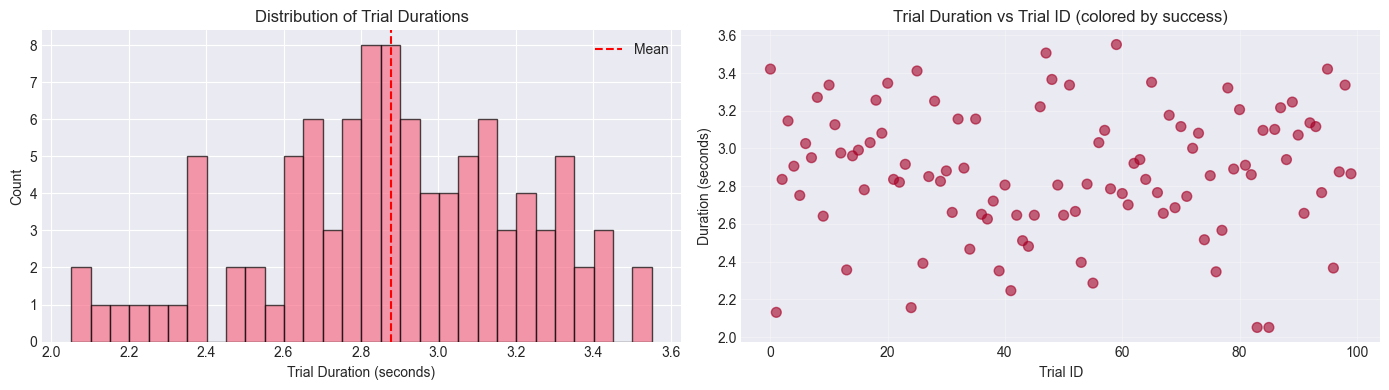

In [4]:
# Create DataFrame for analysis
trials_df = pd.DataFrame(trials)
trials_df['duration'] = trials_df['stop_time'] - trials_df['start_time']

print("Trial Statistics:")
print(f"  Average duration: {trials_df['duration'].mean():.2f} seconds")
print(f"  Success rate: {trials_df['success'].mean()*100:.1f}%")
print(f"  Number of targets per trial: {trials_df['num_targets'].iloc[0]}")

# Visualize trial durations
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Duration histogram
axes[0].hist(trials_df['duration'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Trial Duration (seconds)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Trial Durations')
axes[0].axvline(trials_df['duration'].mean(), color='red', linestyle='--', label='Mean')
axes[0].legend()

# Success by trial
axes[1].scatter(trials_df['trial_id'], trials_df['duration'], 
                c=trials_df['success'], cmap='RdYlGn', alpha=0.6, s=50)
axes[1].set_xlabel('Trial ID')
axes[1].set_ylabel('Duration (seconds)')
axes[1].set_title('Trial Duration vs Trial ID (colored by success)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Understanding Targets (target_id)

A **target** is a physical location in the maze that the subject reaches for. Each trial involves reaching toward one specific target, identified by `target_id` (also called `active_target`).

In center-out reaching tasks, targets are typically arranged in a circle around a center position.

In [5]:
# Analyze targets
unique_targets = trials_df['active_target'].unique()
print(f"🎯 Unique target IDs: {sorted(unique_targets)}")
print(f"   Total number of targets: {len(unique_targets)}\n")

# Count trials per target
target_counts = trials_df['active_target'].value_counts().sort_index()
print("Trials per target:")
for target_id, count in target_counts.items():
    print(f"  Target {target_id}: {count} trials")

🎯 Unique target IDs: [np.int64(0), np.int64(1), np.int64(2)]
   Total number of targets: 3

Trials per target:
  Target 0: 77 trials
  Target 1: 11 trials
  Target 2: 12 trials


### Visualize Target Positions

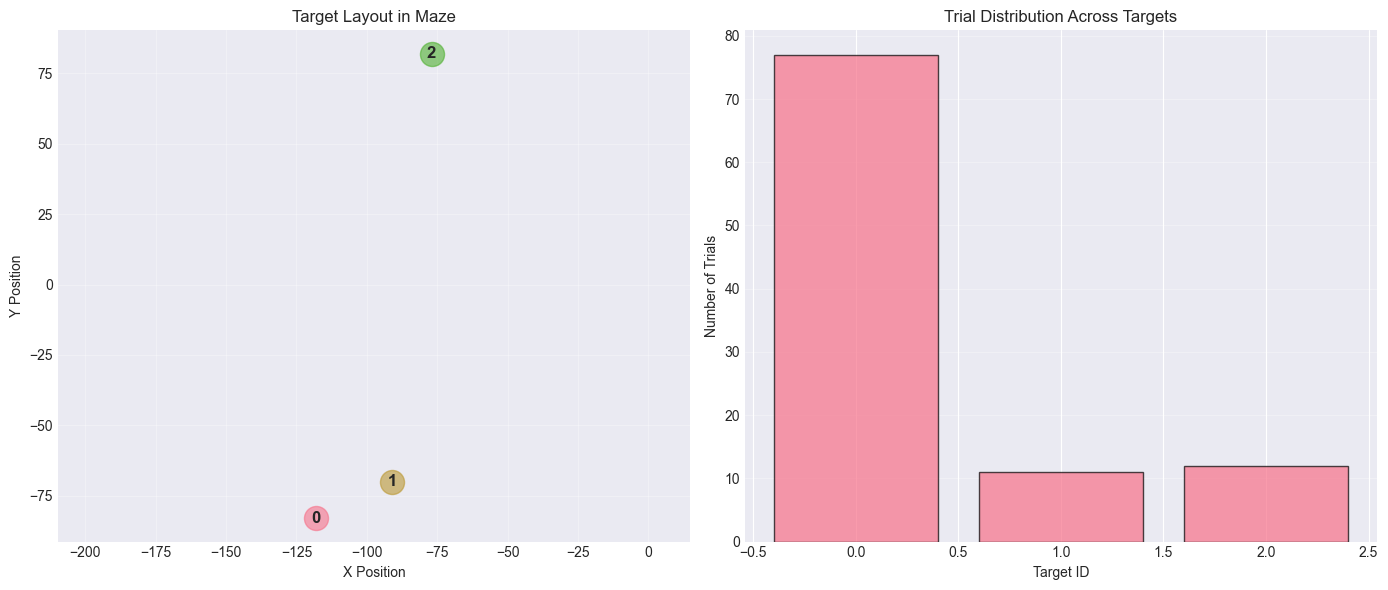


💡 The targets form a center-out reaching pattern!


In [6]:
# Extract target positions from trials
target_positions = {}
for trial in trials:
    target_id = trial['active_target']
    if target_id not in target_positions:
        pos = trial['target_pos'][target_id]
        target_positions[target_id] = (pos[0], pos[1])

# Plot target layout
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Target positions
ax = axes[0]
for target_id, (x, y) in target_positions.items():
    ax.scatter(x, y, s=300, alpha=0.6, label=f'Target {target_id}')
    ax.text(x, y, str(target_id), ha='center', va='center', fontsize=12, fontweight='bold')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Target Layout in Maze')
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Trials per target
ax = axes[1]
ax.bar(target_counts.index, target_counts.values, alpha=0.7, edgecolor='black')
ax.set_xlabel('Target ID')
ax.set_ylabel('Number of Trials')
ax.set_title('Trial Distribution Across Targets')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n💡 The targets form a center-out reaching pattern!")

## 5. Understanding Packets (packet_id / sequence_number)

A **packet** is a single data sample streamed at 40Hz. Each packet contains:
- Neural data (spike counts from all channels)
- Kinematics (hand/cursor velocity and position)
- Target intention (which target is being reached for)
- A unique `sequence_number` (packet_id)

Let's examine packets from a single trial.

In [7]:
# Select a trial to analyze
trial = trials[10]  # Arbitrary choice
print(f"Analyzing Trial {trial['trial_id']}:")
print(f"  Duration: {trial['stop_time'] - trial['start_time']:.2f} seconds")
print(f"  Target ID: {trial['active_target']}")
print(f"  Success: {trial['success']}")

# Calculate number of packets in this trial
trial_duration = trial['stop_time'] - trial['start_time']
num_packets_in_trial = int(trial_duration * 40)  # 40 Hz sampling
print(f"  Number of packets: {num_packets_in_trial} (at 40Hz)\n")

# Sample some packets from this trial
start_time = trial['start_time']
end_time = trial['stop_time']
sample_times = np.linspace(start_time, end_time, min(5, num_packets_in_trial))

print("Sample packets from this trial:")
for i, t in enumerate(sample_times):
    spikes = loader.get_binned_spikes(t, t + 0.025, bin_size_ms=25.0)
    kinematics = loader.get_kinematics(t, t + 0.025, bin_size_ms=25.0)
    
    total_spikes = spikes[0].sum() if len(spikes) > 0 else 0
    vx = kinematics['vx'][0] if len(kinematics['vx']) > 0 else 0
    vy = kinematics['vy'][0] if len(kinematics['vy']) > 0 else 0
    
    print(f"  Packet {i}: time={t:.2f}s, total_spikes={total_spikes}, "
          f"velocity=({vx:.3f}, {vy:.3f})")

Analyzing Trial 10:
  Duration: 3.34 seconds
  Target ID: 0
  Success: True
  Number of packets: 133 (at 40Hz)

Sample packets from this trial:
  Packet 0: time=29.70s, total_spikes=13, velocity=(-8.383, -4.490)
  Packet 1: time=30.53s, total_spikes=10, velocity=(0.132, -3.473)
  Packet 2: time=31.37s, total_spikes=15, velocity=(679.072, 129.862)
  Packet 3: time=32.20s, total_spikes=11, velocity=(2.286, -1.600)
  Packet 4: time=33.04s, total_spikes=0, velocity=(0.438, 0.878)


### Visualize Packets Over Time

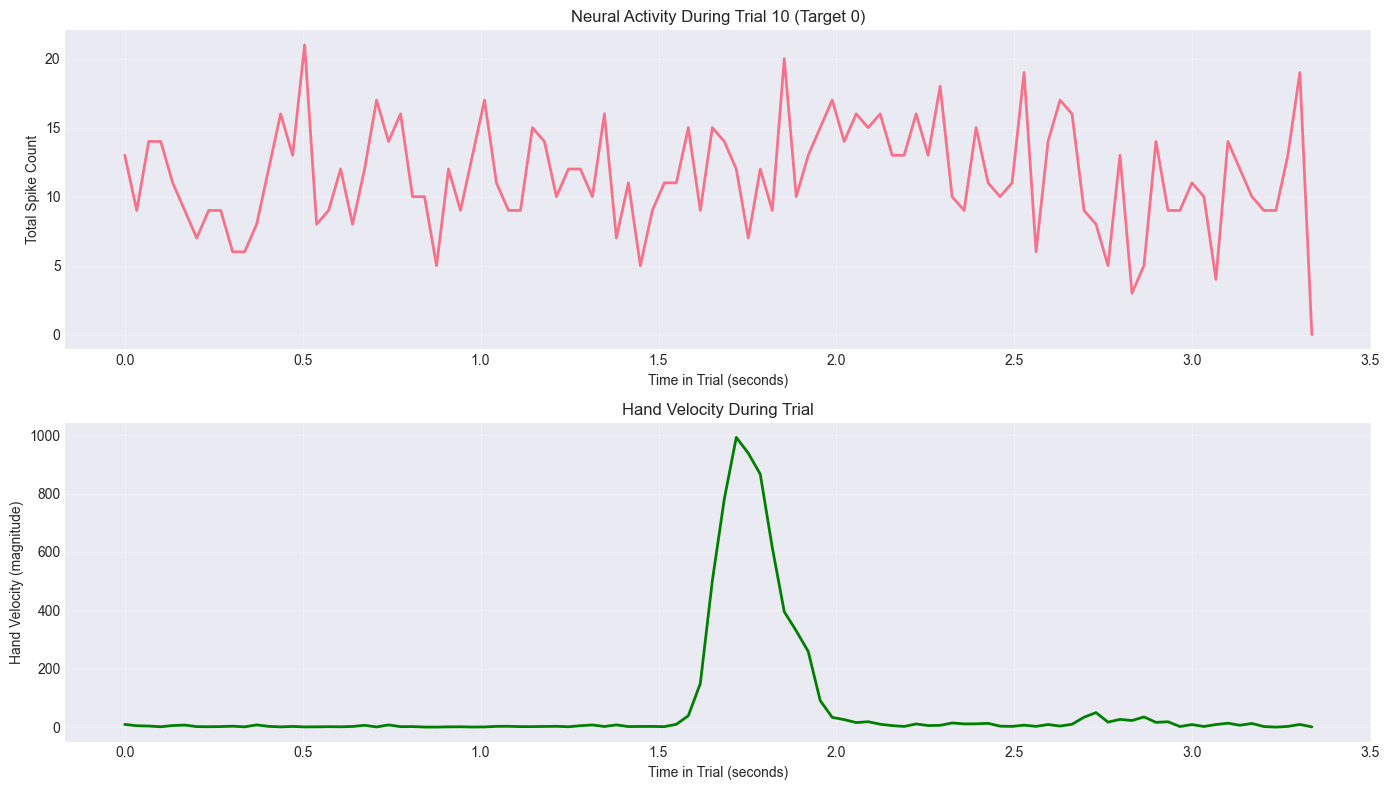


💡 Each point represents one packet (1/40th of a second)


In [8]:
# Analyze packets throughout the trial
num_samples = 100
sample_times = np.linspace(start_time, end_time, num_samples)

spike_data = []
velocity_data = []

for t in sample_times:
    spikes = loader.get_binned_spikes(t, t + 0.025, bin_size_ms=25.0)
    kinematics = loader.get_kinematics(t, t + 0.025, bin_size_ms=25.0)
    
    spike_data.append(spikes[0].sum() if len(spikes) > 0 else 0)
    vx = kinematics['vx'][0] if len(kinematics['vx']) > 0 else 0
    vy = kinematics['vy'][0] if len(kinematics['vy']) > 0 else 0
    velocity_data.append(np.sqrt(vx**2 + vy**2))

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Spike activity
axes[0].plot(sample_times - start_time, spike_data, linewidth=2)
axes[0].set_xlabel('Time in Trial (seconds)')
axes[0].set_ylabel('Total Spike Count')
axes[0].set_title(f'Neural Activity During Trial {trial["trial_id"]} (Target {trial["active_target"]})')
axes[0].grid(True, alpha=0.3)

# Velocity
axes[1].plot(sample_times - start_time, velocity_data, linewidth=2, color='green')
axes[1].set_xlabel('Time in Trial (seconds)')
axes[1].set_ylabel('Hand Velocity (magnitude)')
axes[1].set_title('Hand Velocity During Trial')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Each point represents one packet (1/40th of a second)")

## 6. The Hierarchical Relationship

Let's visualize how these concepts relate to each other:

```
Dataset (mc_maze.nwb)
│
├── Trial 0 (trial_id=0) → reaches for Target 3 (target_id=3)
│   ├── Packet 0 (sequence_number=0)
│   ├── Packet 1 (sequence_number=1)
│   ├── ...
│   └── Packet N (sequence_number=N)
│
├── Trial 1 (trial_id=1) → reaches for Target 5 (target_id=5)
│   ├── Packet N+1 (sequence_number=N+1)
│   ├── Packet N+2 (sequence_number=N+2)
│   └── ...
│
└── ...
```

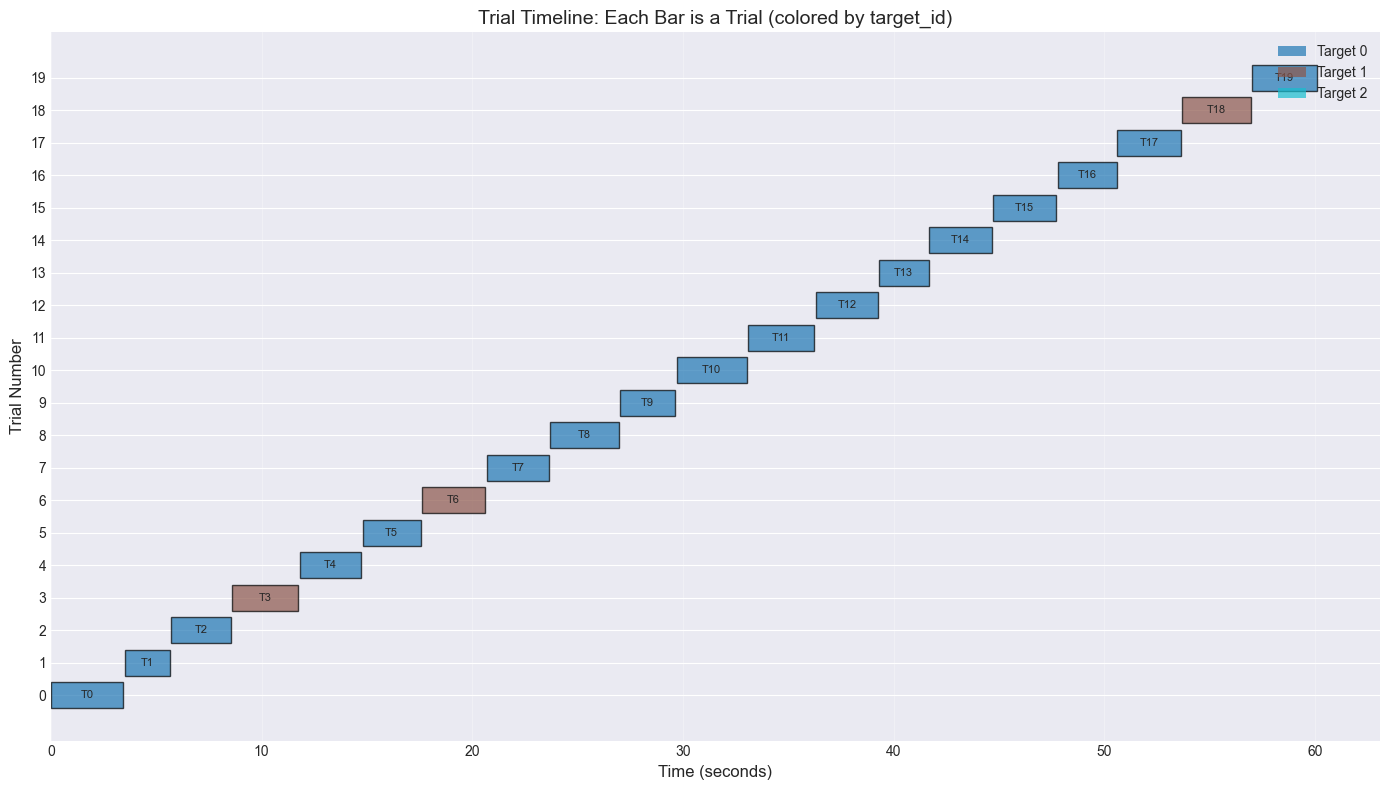


📊 Each horizontal bar represents one trial
   The color indicates which target (target_id) is being reached
   The length indicates trial duration
   Each trial contains many packets (40 per second)


In [9]:
# Create a summary visualization
fig, ax = plt.subplots(figsize=(14, 8))

# Plot each trial as a horizontal bar
y_pos = 0
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_targets)))
target_color_map = {target: colors[i] for i, target in enumerate(sorted(unique_targets))}

for trial in trials[:20]:  # First 20 trials for clarity
    duration = trial['stop_time'] - trial['start_time']
    color = target_color_map[trial['active_target']]
    ax.barh(y_pos, duration, left=trial['start_time'], 
            height=0.8, color=color, alpha=0.7, edgecolor='black')
    ax.text(trial['start_time'] + duration/2, y_pos, 
            f"T{trial['trial_id']}", ha='center', va='center', fontsize=8)
    y_pos += 1

# Create legend for targets
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=target_color_map[t], alpha=0.7, label=f'Target {t}') 
                   for t in sorted(unique_targets)]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Trial Number', fontsize=12)
ax.set_title('Trial Timeline: Each Bar is a Trial (colored by target_id)', fontsize=14)
ax.set_yticks(range(20))
ax.set_yticklabels([f'{i}' for i in range(20)])
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n📊 Each horizontal bar represents one trial")
print("   The color indicates which target (target_id) is being reached")
print("   The length indicates trial duration")
print("   Each trial contains many packets (40 per second)")

## 7. Filtering by Target ID

One powerful feature of PhantomLink is the ability to stream only packets for specific targets. This is useful for training decoders for specific reach directions.

Target 0: 77 trials
Target 3: 0 trials

You can filter WebSocket streams:
  ws://localhost:8000/stream?target_id=0  → only Target 0 data
  ws://localhost:8000/stream?target_id=3  → only Target 3 data


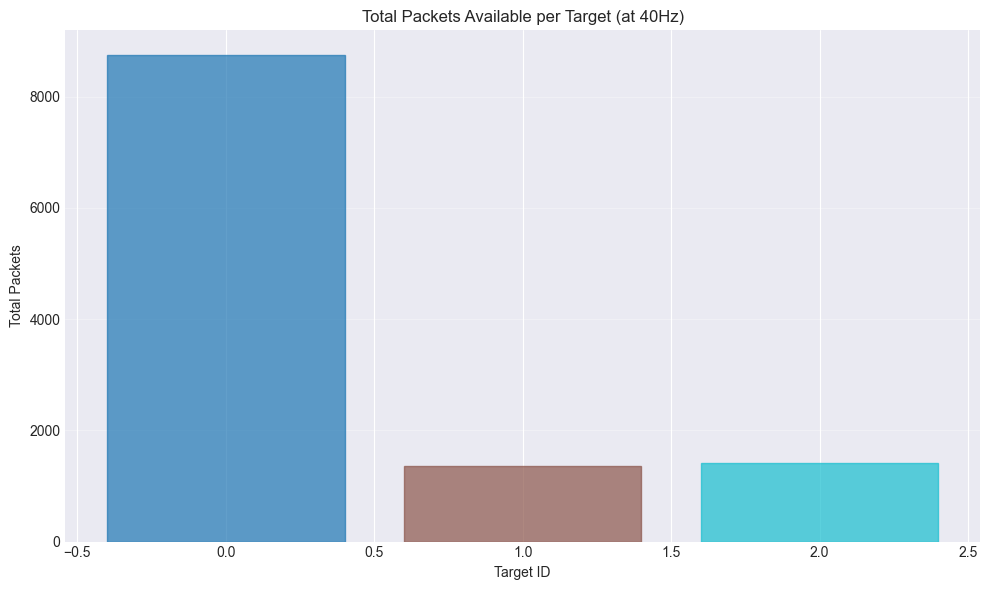

In [10]:
# Compare trials for different targets
target_0_trials = loader.get_trials_by_target(0)
target_3_trials = loader.get_trials_by_target(3)

print(f"Target 0: {len(target_0_trials)} trials")
print(f"Target 3: {len(target_3_trials)} trials")
print(f"\nYou can filter WebSocket streams:")
print(f"  ws://localhost:8000/stream?target_id=0  → only Target 0 data")
print(f"  ws://localhost:8000/stream?target_id=3  → only Target 3 data")

# Calculate total packets per target
total_packets_by_target = {}
for target_id in unique_targets:
    target_trials = loader.get_trials_by_target(target_id)
    total_duration = sum(t['stop_time'] - t['start_time'] for t in target_trials)
    total_packets = int(total_duration * 40)
    total_packets_by_target[target_id] = total_packets

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
targets = sorted(total_packets_by_target.keys())
packets = [total_packets_by_target[t] for t in targets]
bars = ax.bar(targets, packets, alpha=0.7, edgecolor='black')

# Color bars by target
for bar, target in zip(bars, targets):
    bar.set_color(target_color_map[target])

ax.set_xlabel('Target ID')
ax.set_ylabel('Total Packets')
ax.set_title('Total Packets Available per Target (at 40Hz)')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Summary: Quick Reference

| Concept | Description | Example Values | Typical Count |
|---------|-------------|----------------|---------------|
| **trial_id** | Unique identifier for each reach sequence | 0, 1, 2, ..., 99 | 100 trials in MC_Maze |
| **target_id** | Physical target position being reached | 0, 1, 2 | 3 targets in MC_Maze |
| **packet_id / sequence_number** | Monotonic counter for 40Hz packets | 0, 1, 2, ..., 11745 | ~40 per second |

### Key Relationships:
- **One trial** contains **many packets** (duration × 40)
- **One trial** reaches for **one target**
- **One target** is reached in **multiple trials**
- **Packets** are numbered continuously across all trials

### Actual Dataset Values:
- Total Trials: **100** (trial_id 0-99)
- Total Targets: **3** (target_id 0, 1, 2)
- Total Packets: **11,746** (sequence_number 0-11745)
- Neural Channels: **142**
- Duration: **293.7 seconds** (4.9 minutes)
- Success Rate: **100%** across all targets

In [13]:
# Final summary statistics
print("=" * 60)
print("PHANTOMLINK DATASET SUMMARY")
print("=" * 60)
print(f"\n📦 Total Packets: {loader.num_timesteps:,}")
print(f"📋 Total Trials: {len(trials)}")
print(f"🎯 Total Targets: {len(unique_targets)}")
print(f"🧠 Neural Channels: {loader.num_channels}")
print(f"⏱️  Total Duration: {loader.duration:.1f}s ({loader.duration/60:.1f} minutes)")
print(f"📡 Streaming Rate: 40 Hz (1 packet every 25ms)")
print("\n" + "=" * 60)

# Calculate some interesting stats
avg_packets_per_trial = loader.num_timesteps / len(trials)
avg_trial_duration = trials_df['duration'].mean()

print(f"\n📊 Average packets per trial: {avg_packets_per_trial:.0f}")
print(f"   (= {avg_trial_duration:.2f} seconds × 40 Hz)")

# Success rate by target
success_by_target = trials_df.groupby('active_target')['success'].mean() * 100
print(f"\n✓ Success rate by target:")
for target_id in sorted(success_by_target.index):
    print(f"   Target {target_id}: {success_by_target[target_id]:.1f}%")

print("\n" + "=" * 60)

PHANTOMLINK DATASET SUMMARY

📦 Total Packets: 11,746
📋 Total Trials: 100
🎯 Total Targets: 3
🧠 Neural Channels: 142
⏱️  Total Duration: 293.7s (4.9 minutes)
📡 Streaming Rate: 40 Hz (1 packet every 25ms)


📊 Average packets per trial: 117
   (= 2.88 seconds × 40 Hz)

✓ Success rate by target:
   Target 0: 100.0%
   Target 1: 100.0%
   Target 2: 100.0%



## 9. Practical Examples

### Example 1: Stream all data
```python
ws://localhost:8000/stream
```
Streams all packets from all trials and targets.

### Example 2: Stream only Target 0 data
```python
ws://localhost:8000/stream?target_id=0
```
Streams only packets when the subject is reaching for target 0.

### Example 3: Stream only Trial 42
```python
ws://localhost:8000/stream?trial_id=42
```
Streams only packets from trial 42 (one complete reach).

### Example 4: Get trial information
```python
GET http://localhost:8000/api/trials
```
Returns metadata for all trials.

### Example 5: Get specific trial details
```python
GET http://localhost:8000/api/trials/{trial_id}
```
Returns detailed information about a specific trial.

## 10. Cleanup

In [12]:
# Close the data loader to release resources
loader.close()
print("✓ Dataset closed successfully")

✓ Dataset closed successfully
